# Training the model on the feature extracted data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid")

In [5]:
from scipy.sparse import csr_matrix, load_npz

train = load_npz('2_Extracted_Data.npz')
train.shape

(39048, 2634)

In [9]:
labels = pd.read_csv('2_Extracted_Data_labels.csv')
labels = labels >= 7
labels = labels.astype(np.int)

In [16]:
# Splitting the extracted data for modelling

X = train # traning data
y = labels.stars.values #label data

X_train, X_cv, y_train, y_cv = train_test_split( 
              X, y, test_size = 0.4, random_state = 42, stratify = y) 
X_cv, X_test, y_cv, y_test = train_test_split(X_cv, y_cv, test_size=0.1, random_state=42, stratify=y_cv)

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(23428, 2634)
(14058, 2634)
(1562, 2634)


In [17]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

In [18]:
#Training Function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [19]:
def trainModelGrid(estimator, params, train, y, cv=5):
    model = GridSearchCV(estimator, params, n_jobs=-1, scoring='accuracy',cv=cv)
    model.fit(train, y)
    return model

In [20]:
def trainModelRandom(estimator, params, train, y, cv=5, n_iter=5):
    model = RandomizedSearchCV(estimator, params, n_jobs=-1, scoring='accuracy',cv=cv, n_iter=n_iter)
    model.fit(train, y)
    return model

# Trying to train the data using various classification models

## 1. LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
logreg = LogisticRegression(penalty='l1', dual=False, solver='liblinear', random_state=0)
params_dist = {  
    "max_iter": st.randint(100,300),
    "C": st.uniform(1.1, 3.0)
}
params_grid = {  
    "max_iter": [200, 210, 220],
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [25]:
%%time 
model = RandomizedSearchCV(logreg, params_dist, n_jobs=-1, scoring='accuracy',cv=5, n_iter=5)
model.fit(X_train, y_train)

CPU times: total: 3.5 s
Wall time: 33.9 s


In [26]:
model.best_score_

0.7841047357851061

In [27]:
model.best_estimator_

LogisticRegression(C=1.2048854694597482, max_iter=277, penalty='l1',
                   random_state=0, solver='liblinear')

In [28]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_cv, cvPredicted)

0.7880921895006402

## 2. DecisionTreeClassifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
params_grid = {
    "max_depth" : np.arange(1, 25, 1)
}

In [34]:
%%time
model = GridSearchCV(dt, params_grid, n_jobs=-1, scoring='accuracy',cv=5)
model.fit(X_train, y_train)

CPU times: total: 1.17 s
Wall time: 22.7 s


In [35]:
model.best_score_

0.7747142080841181

In [36]:
model.best_estimator_

DecisionTreeClassifier(max_depth=10, random_state=0)

In [37]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [38]:
accuracy_score(y_cv, cvPredicted)

0.7804808649879073

In [39]:
model.cv_results_['mean_test_score']

array([0.72669453, 0.72750565, 0.73996957, 0.75375634, 0.75764041,
       0.76506713, 0.76856755, 0.77142727, 0.77454327, 0.77471421,
       0.77471393, 0.77398839, 0.77138452, 0.76916496, 0.76745766,
       0.76600647, 0.76498191, 0.76387229, 0.76096972, 0.75934772,
       0.75939034, 0.75785372, 0.75537807, 0.7549514 ])

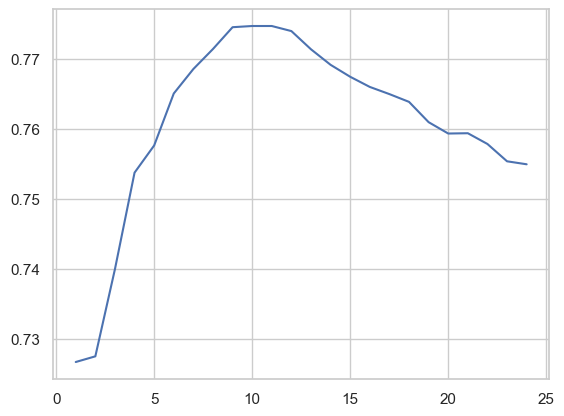

In [40]:
sns_plot = sns.lineplot(x=np.arange(1,25,1), y=model.cv_results_['mean_test_score'])
sns_plot.figure.savefig('decision-tree-depth-vs-score.png')

In [41]:
model.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

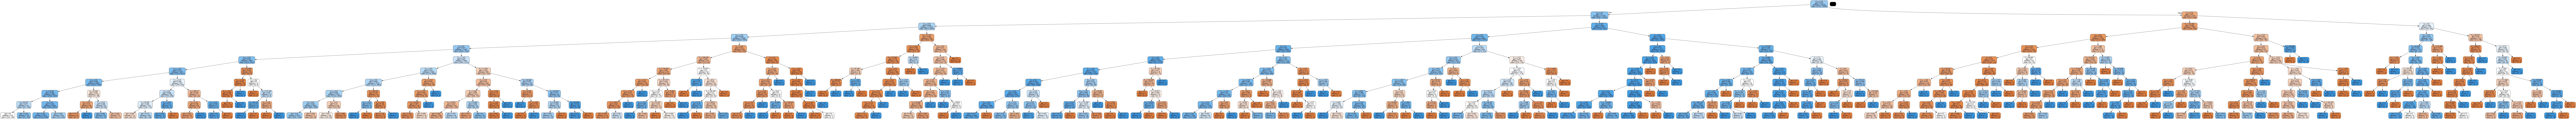

In [43]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

export_graphviz(model.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('dtree-graph-full-dataset.png')
Image(graph.create_png())

## 3. XGBClassifier

In [44]:
from xgboost.sklearn import XGBClassifier

In [45]:
xgb = XGBClassifier(random_state=0)

In [46]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [47]:
%%time
model = trainModelRandom(xgb, params_dist, X_train, y_train, cv=20, n_iter=50)

CPU times: total: 53.2 s
Wall time: 10min 1s


In [48]:
model.best_score_

0.7917024188071804

In [49]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.947424709436449, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.718839967535035, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4311888127347861, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=33, max_leaves=0, min_child_weight=12.56833622889916,
              missing=nan, monotone_constraints='()', n_estimators=39, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [50]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [51]:
accuracy_score(y_cv, cvPredicted)

0.7969127898705364

## 4. Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf = RandomForestClassifier(random_state=0)

In [54]:
params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40)
}

In [55]:
%%time
model = trainModelRandom(rf, params_dist, X_train, y_train)

CPU times: total: 7.98 s
Wall time: 28.2 s


In [56]:
model.best_score_

0.7845313568289203

In [57]:
model.best_estimator_

RandomForestClassifier(max_depth=36, n_estimators=32, random_state=0)

In [58]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [59]:
accuracy_score(y_cv, cvPredicted)

0.7893725992317542

## 5. Support Vector Classifier

In [60]:
from sklearn.svm import LinearSVC

In [61]:
svc = LinearSVC(dual=False, random_state=0)

In [62]:
params = {  
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [63]:
params_dist = {  
    "C": st.uniform(1.0, 2.0)
}

In [64]:
%%time
model = trainModelRandom(svc, params_dist, X_train, y_train)

CPU times: total: 828 ms
Wall time: 11.2 s


In [65]:
model.best_score_

0.7841900599938689

In [66]:
model.best_estimator_

LinearSVC(C=1.9088715187215253, dual=False, random_state=0)

In [67]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [68]:
accuracy_score(y_cv, cvPredicted)

0.7880921895006402